# CNN — Understanding Kernels / Filters

In this notebook, we will explore how **filters (kernels)** work in a Convolutional Neural Network (CNN).
We will apply classic filters to images with vertical, horizontal, and diagonal lines to visualize how each filter **activates** certain features and builds the **feature map**.

---

A **kernel** is a small matrix (e.g., 3x3) that is slid over the input image performing an operation called **convolution**:
it multiplies each element by each region of the image and sums the results → produces a single value per position.

$$\text{Feature Map}[i,j] = \sum_{m}\sum_{n} I[i+m,\, j+n] \cdot K[m,n]$$

where $I$ is the image and $K$ is the kernel.

---

## How does the CNN know which filters to use?

The filters **are not predefined**. At the start of training, they are initialized with **random** values ​​(e.g., He or Xavier initialization).

During training, using **backpropagation**, the kernel values ​​are adjusted to minimize the loss function.

> The network *learns on its own* that it is advantageous to detect edges, corners, textures, etc.

> In early layers, the learned filters are usually very similar to the classic filters we will see here.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import convolve
from PIL import Image
import os

# somme parameters are defined in matplot
plt.rcParams['figure.facecolor'] = '#F8F9FA'
plt.rcParams['axes.facecolor'] = '#F8F9FA'
plt.rcParams['font.family'] = 'DejaVu Sans'


## Load Images

We uploaded images containing vertical, horizontal, and diagonal lines.

If you don't have your own files at the moment, the notebook can also automatically generate synthetic images.

In [25]:
def generates_synthetic_images(tipo='vertical', size=128):
    "Generates synthetic images with lines according to the indicated type."
    img = np.zeros((size, size), dtype=np.float32)
    
    if tipo == 'vertical':
        # Vertical lines
        for x in range(8, size, 16):
            img[:, x-1:x+2] = 1.0
            
    elif tipo == 'horizontal':
        # Horizontal lines
        for y in range(8, size, 16):
            img[y-1:y+2, :] = 1.0
            
    elif tipo == 'diagonal':
        # Diagonal lines (45°)
        for offset in range(-size, size, 16):
            for i in range(size):
                j = i + offset
                if 0 <= j < size:
                    img[i, j] = 1.0
                    if j+1 < size: img[i, j+1] = 1.0
    return img


def load_image(path):
    "Loads an image from disk and converts it to normalized grayscale."
    img = Image.open(path).convert('L')
    return np.array(img, dtype=np.float32) / 255.0


# -------------------------------------------------------------------
# load images from path
# -------------------------------------------------------------------
RUTAS = {
    'image': 'kenels.png', 
    'imageA': 'kenels.png'
}

imagenes = {}
for tipo, ruta in RUTAS.items():
    if ruta and os.path.exists(ruta):
        imagenes[tipo] = load_image(ruta)
        print(f'Image "{tipo}" load from {ruta}')
    else:
        imagenes[tipo] = generates_synthetic_images(tipo)
        print(f'Image "{tipo}" synthetically generated (no path found)')

print(f'\nImage size: {list(imagenes.values())[0].shape}')

Image "image" load from kenels.png
Image "imageA" load from kenels.png

Image size: (633, 633)


/tmp/ipykernel_8102/344950851.py:8: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  plt.tight_layout()
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


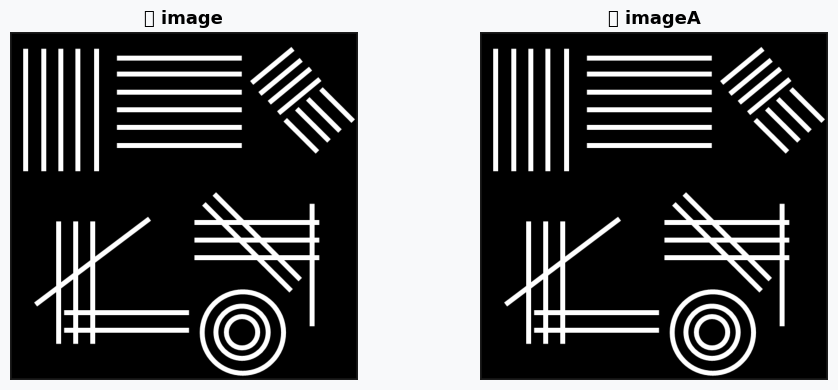

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (tipo, img) in zip(axes, imagenes.items()):
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'🖼️ {tipo}', fontsize=13, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

---

## Kernels

We define the **three most common filters** in CNN for feature detection:

| Filter | Detect | Direction |
|--------|---------|----------|
| **Sobel Vertical** | Vertical edges | ↕ |
| **Sobel Horizontal** | Horizontales edges | ↔ |
| **Laplaciano** | Edges in all directions | Alldirections |
| **Prewitt Diagonal** | Bordes diagonales | ↗ ↘ |


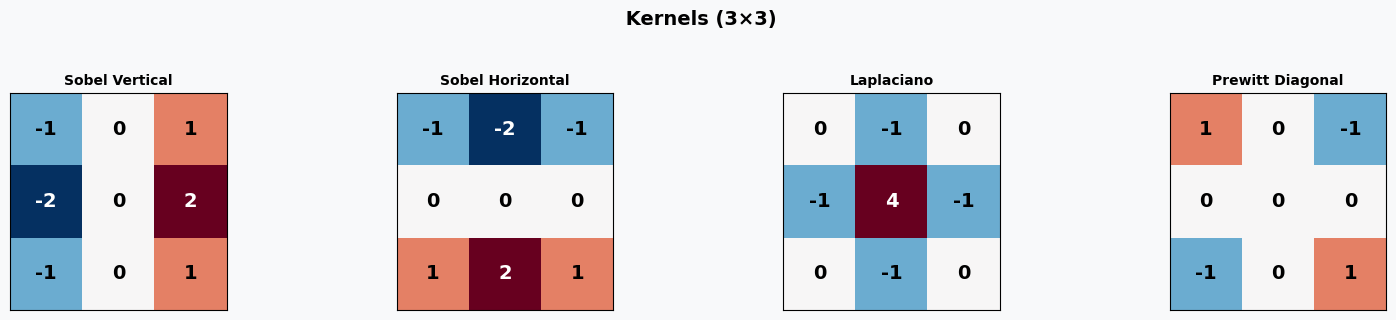

In [29]:

filtros = {
    'Sobel Vertical': np.array([
        [-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1]
    ], dtype=np.float32),

    'Sobel Horizontal': np.array([
        [-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]
    ], dtype=np.float32),

    'Laplaciano': np.array([
        [ 0, -1,  0],
        [-1,  4, -1],
        [ 0, -1,  0]
    ], dtype=np.float32),

    'Prewitt Diagonal': np.array([
        [ 1,  0, -1],
        [ 0,  0,  0],
        [-1,  0,  1]
    ], dtype=np.float32),
}

# Plot for ernels
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for ax, (nombre, kernel) in zip(axes, filtros.items()):
    im = ax.imshow(kernel, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(nombre, fontsize=10, fontweight='bold')
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f'{kernel[i,j]:.0f}', ha='center', va='center',
                   fontsize=14, fontweight='bold',
                   color='white' if abs(kernel[i,j]) > 1 else 'black')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(' Kernels (3×3)', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

---

## Feature Maps

Now we apply each filter to each image and observe the resulting **feature map**.

The key idea: a filter that detects vertical edges will **only activate strongly** in regions where the image has that pattern.

> 🔵 **High** (bright) values ​​= the filter found the pattern it was looking for 
> ⚫ **Low** (dark) values ​​= the pattern is not present in that area

In [32]:
def apply_filter(imagen, kernel):
    "Apply convolution and return the feature map (using ReLU)."""
    fm = convolve(imagen, kernel, mode='constant', cval=0.0)
    return np.maximum(fm, 0)


# Calcular todos los feature maps
results = {}
for tipo_img, img in imagenes.items():
    results[tipo_img] = {}
    for nombre_filtro, kernel in filtros.items():
        results[tipo_img][nombre_filtro] = apply_filter(img, kernel)

print(f'   {len(imagenes)} images × {len(filtros)} filters = {len(imagenes)*len(filtros)} feature maps')

   2 images × 4 filters = 8 feature maps


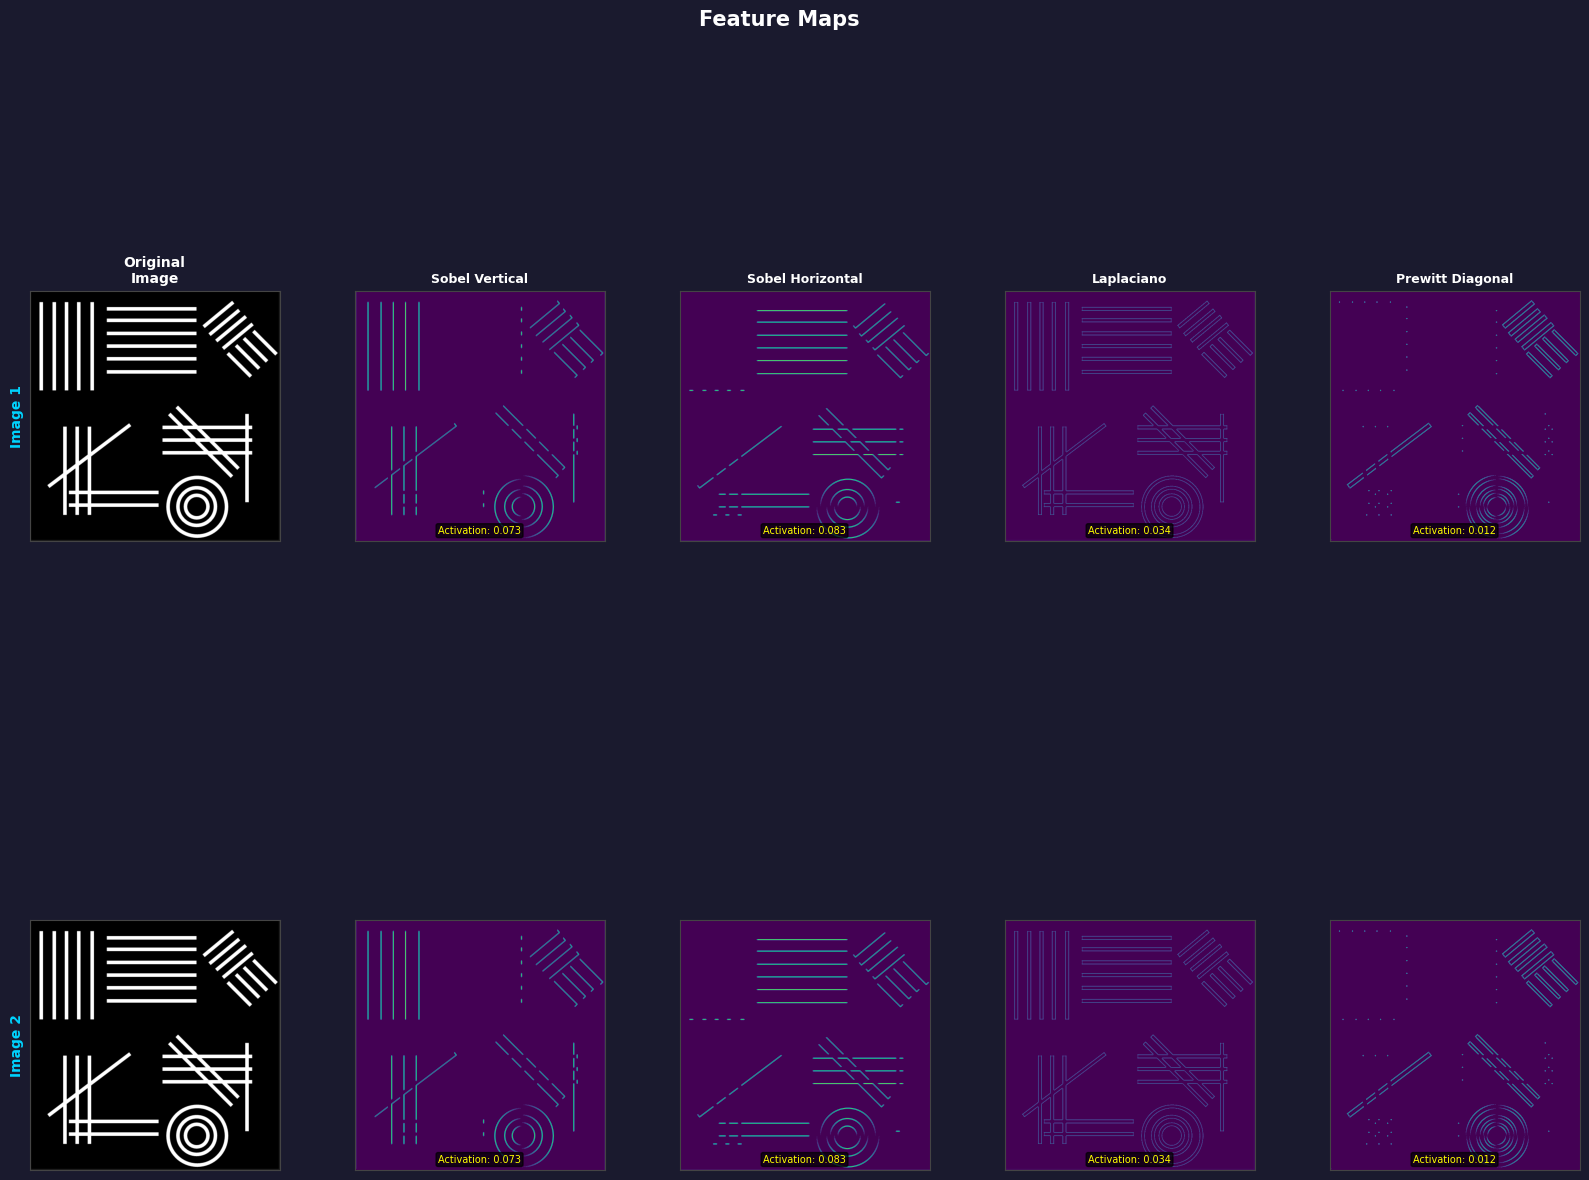

In [37]:
nombres_filtros = list(filtros.keys())
tipos_imagenes  = list(imagenes.keys())

fig = plt.figure(figsize=(20, 14))
fig.patch.set_facecolor('#1a1a2e')

n_filas = len(tipos_imagenes)
n_cols  = len(filtros) + 1

gs = gridspec.GridSpec(n_filas, n_cols, hspace=0.4, wspace=0.3)

labels_cols = ['Original Image'] + [nf.split('\n')[0] for nf in nombres_filtros]
labels_rows = ['Image 1', 'Image 2']

for row, tipo in enumerate(tipos_imagenes):
    for col in range(n_cols):
        ax = fig.add_subplot(gs[row, col])
        ax.set_facecolor('#1a1a2e')
        
        if col == 0:
            # Original Image
            ax.imshow(imagenes[tipo], cmap='gray', vmin=0, vmax=1)
            if row == 0:
                ax.set_title('Original\nImage', color='white', fontsize=10, fontweight='bold')
            ax.set_ylabel(f'{labels_rows[row]}', color='#00d4ff',
                         fontsize=10, fontweight='bold')
        else:
            nombre_filtro = nombres_filtros[col - 1]
            fm = results[tipo][nombre_filtro]
            
            # normalization
            fm_vis = fm / (fm.max() + 1e-8)
            ax.imshow(fm_vis, cmap='viridis', vmin=0, vmax=1)
            
            if row == 0:
                ax.set_title(nombres_filtros[col-1].split('\n')[0], 
                           color='white', fontsize=9, fontweight='bold')
            
            # Mostrar intensidad media (qué tan activado está el filtro)
            intensidad = fm.mean()
            ax.text(0.5, 0.03, f'Activation: {intensidad:.3f}',
                   transform=ax.transAxes, ha='center',
                   color='yellow', fontsize=7,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))
        
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor('#444')

fig.suptitle('Feature Maps',
            color='white', fontsize=15, fontweight='bold', y=1.01)

plt.savefig('/tmp/feature_maps_completo.png', dpi=150, bbox_inches='tight',
           facecolor='#1a1a2e')
plt.show()


---

## Zoom: one Image all filters

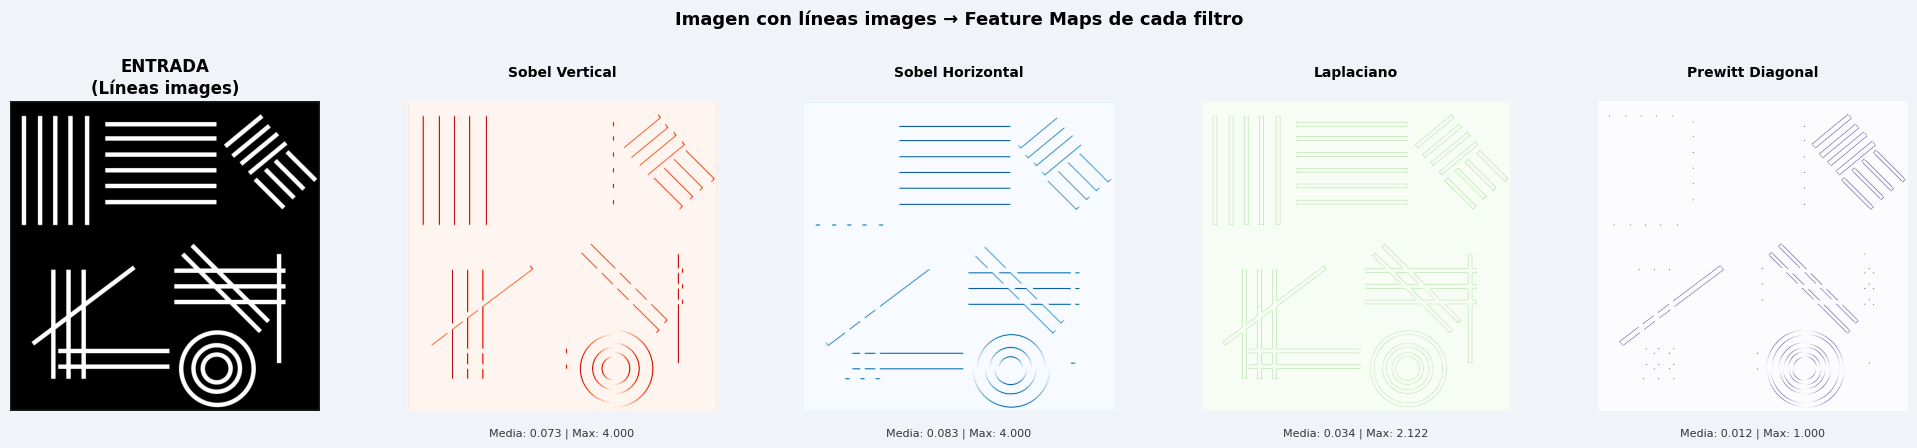

In [41]:
# ============================================================
#  ANÁLISIS DETALLADO: imagen vertical con todos los filtros
# ============================================================

IMAGEN_DEMO = 'image' 
img_demo = imagenes[IMAGEN_DEMO]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_facecolor('#f0f4f8')

# Imagen original
axes[0].imshow(img_demo, cmap='gray')
axes[0].set_title(f'ENTRADA\n(Líneas {IMAGEN_DEMO}s)', fontweight='bold', fontsize=12)
axes[0].axis('off')

# Añadir flecha entre original y feature maps
colormaps = ['Reds', 'Blues', 'Greens', 'Purples']

for idx, (nombre, kernel) in enumerate(filtros.items()):
    fm = results[IMAGEN_DEMO][nombre]
    fm_vis = fm / (fm.max() + 1e-8)
    
    ax = axes[idx + 1]
    ax.imshow(fm_vis, cmap=colormaps[idx])
    
    nombre_corto = nombre.split('\n')[0]
    subtitulo = nombre.split('\n')[1] if '\n' in nombre else ''
    ax.set_title(f'{nombre_corto}\n{subtitulo}', fontweight='bold', fontsize=10)
    ax.axis('off')
    
    # Estadísticas
    ax.text(0.5, -0.08,
           f'Media: {fm.mean():.3f} | Max: {fm.max():.3f}',
           transform=ax.transAxes, ha='center', fontsize=8, color='#333')

plt.suptitle(f'Imagen con líneas {IMAGEN_DEMO}s → Feature Maps de cada filtro',
            fontsize=13, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

---

## Comparison 

Average activation per filter and image (higher = the filter detected that pattern more)::

             Sobel Vertical  Sobel Horizontal  Laplaciano  Prewitt Diagonal
Img. Image           0.0728            0.0831      0.0339             0.012
Img. Imagea          0.0728            0.0831      0.0339             0.012


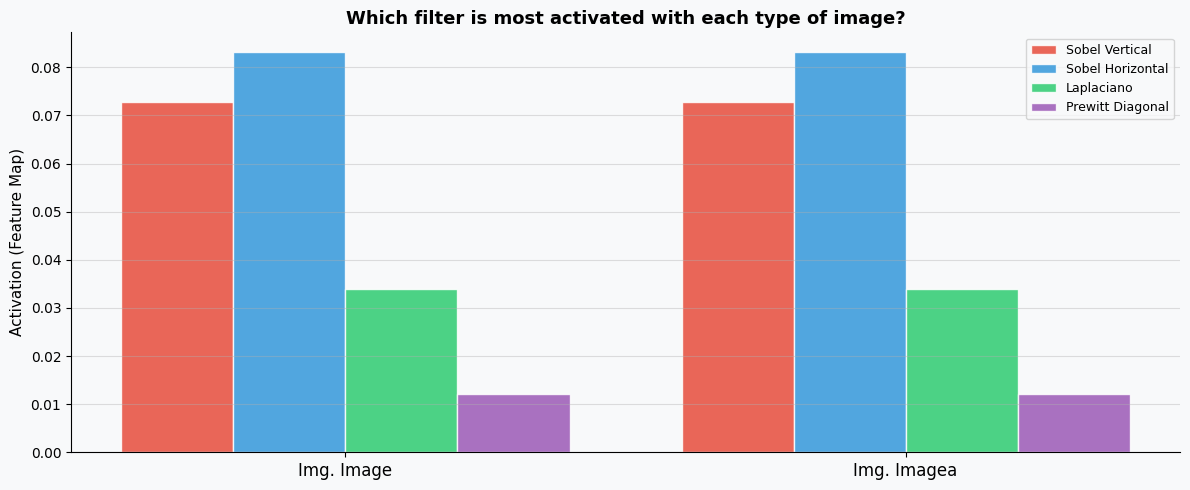

In [47]:
import pandas as pd

datos_tabla = {}
for tipo in tipos_imagenes:
    datos_tabla[f'Img. {tipo.capitalize()}'] = {
        nf.split('\n')[0]: round(resultados[tipo][nf].mean(), 4)
        for nf in nombres_filtros
    }

df = pd.DataFrame(datos_tabla).T
print('Average activation per filter and image (higher = the filter detected that pattern more)::\n')
print(df.to_string())

# Gráfica de barras
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(tipos_imagenes))
ancho = 0.2
colores = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for idx, (nombre_filtro, color) in enumerate(zip(nombres_filtros, colores)):
    valores = [resultados[tipo][nombre_filtro].mean() for tipo in tipos_imagenes]
    bars = ax.bar(x + idx * ancho, valores, ancho, 
                 label=nombre_filtro.split('\n')[0], 
                 color=color, alpha=0.85, edgecolor='white')

ax.set_xticks(x + ancho * 1.5)
ax.set_xticklabels([f'Img. {t.capitalize()}' for t in tipos_imagenes], fontsize=12)
ax.set_ylabel('Activation (Feature Map)', fontsize=11)
ax.set_title('Which filter is most activated with each type of image?', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.set_facecolor('#f8f9fa')
ax.grid(axis='y', alpha=0.4)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


---

## In a real CNN

```
Random Initialization → Forward Pass → Loss Calculation → Backpropagation → Update Kernel Weights
     (random)                                                                  (gradiend descent)
         ↑_______________________________________________________________↓
                              (repeats epoch by epochs)
```

- **Layer 1**: Learn simple filters → edges, lines 
- **Layer 2**: Combine simple filters → corners, curves
- **Layer N**: Combine everything → parts of objects, complete objects

---

Key takeaway: The filters we saw (Sobel, Laplacian) were designed manually by mathematicians.

A CNN automatically learns equivalent or better filters from the data and prediction error.

It doesn't need to know beforehand what to look for—it learns what to look for because it's useful for the task.